In [ ]:
import torch
import torchvision

import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from PIL import Image
from resnet20.ResNet20 import resnet20

# Choose variants here:

In [ ]:
trained_model = True
arch = 'ResNet20'

## System setup:

In [ ]:
import inversefed
setup = inversefed.utils.system_startup()
defs = inversefed.training_strategy('conservative')

loss_fn, trainloader, validloader =  inversefed.construct_dataloaders('CIFAR100', defs)

model = resnet20()

if(trained_model):
    model.load_state_dict(torch.load('./models/trainedResNet20.pt', map_location=torch.device('cpu')))

model.to(**setup)
model.eval();

Currently evaluating -------------------------------:
Monday, 06. February 2023 06:56PM
CPUs: 6, GPUs: 0 on Albi.
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
dm = torch.as_tensor(inversefed.consts.cifar100_mean, **setup)[:, None, None]
ds = torch.as_tensor(inversefed.consts.cifar100_std, **setup)[:, None, None]
def plot(tensor):
    tensor = tensor.clone().detach()
    tensor.mul_(ds).add_(dm).clamp_(0, 1)
    if tensor.shape[0] == 1:
        return plt.imshow(tensor[0].permute(1, 2, 0).cpu());
    else:
        fig, axes = plt.subplots(1, tensor.shape[0], figsize=(12, tensor.shape[0]*12))
        for i, im in enumerate(tensor):
            axes[i].imshow(im.permute(1, 2, 0).cpu());

# Reconstruct

### Build the input (ground-truth) gradient

['apple']


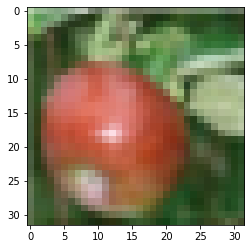

In [ ]:
idx = 1014
# 8112 # the beagle
# 1200 # the owl
# 11794 # the German shepherd
# 19449 # the panda
# np.random.randint(len(validloader.dataset))

img, label = validloader.dataset[idx]
labels = torch.as_tensor((label,), device=setup['device'])
ground_truth = img.to(**setup).unsqueeze(0)
plot(ground_truth);
print([trainloader.dataset.classes[l] for l in labels]);

In [ ]:
ground_truth_denormalized = torch.clamp(ground_truth * ds + dm, 0, 1)
torchvision.utils.save_image(ground_truth_denormalized, f'{idx}_{arch}_ImageNet_input.png')

In [ ]:
model.zero_grad()
target_loss, _, _ = loss_fn(model(ground_truth), labels)
input_gradient = torch.autograd.grad(target_loss, model.parameters())
input_gradient = [grad.detach() for grad in input_gradient]
full_norm = torch.stack([g.norm() for g in input_gradient]).mean()
print(f'Full gradient norm is {full_norm:e}.')

## Invert the gradient signal

## Normal Settings

It: 0. Rec. loss: 1.0660.
It: 500. Rec. loss: 0.2753.
It: 1000. Rec. loss: 0.2254.
It: 1500. Rec. loss: 0.2134.
It: 2000. Rec. loss: 0.2555.
It: 2500. Rec. loss: 0.2304.
It: 3000. Rec. loss: 0.2320.
It: 3500. Rec. loss: 0.1786.
It: 4000. Rec. loss: 0.1782.
It: 4500. Rec. loss: 0.1527.
It: 5000. Rec. loss: 0.1294.
It: 5500. Rec. loss: 0.1199.
It: 6000. Rec. loss: 0.1191.
It: 6500. Rec. loss: 0.1185.
It: 7000. Rec. loss: 0.1157.
It: 7500. Rec. loss: 0.1154.
It: 7999. Rec. loss: 0.1159.
Choosing optimal result ...
Optimal result score: 0.0983
Total time: 1637.5801031589508.


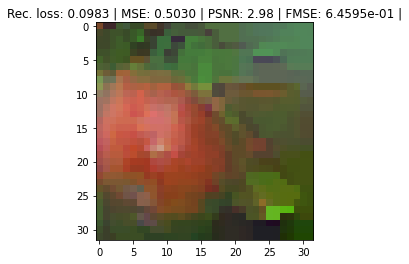

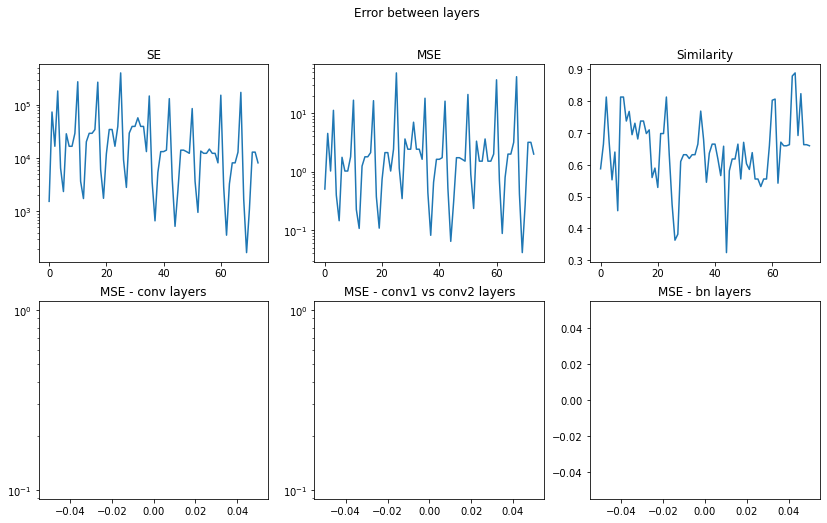

In [ ]:
config = dict(signed=True,
              boxed=True,
              cost_fn='sim',
              indices='def',
              weights='equal',
              lr=0.1,
              optim='adam',
              restarts=1,
              max_iterations=3000,
              total_variation=1e-1,
              init='randn',
              filter='none',
              lr_decay=True,
              scoring_choice='loss')

rec_machine = inversefed.GradientReconstructor(model, (dm, ds), config, num_images=1)
output, stats = rec_machine.reconstruct(input_gradient, labels, img_shape=(3, 32, 32))

test_mse = (output.detach() - ground_truth).pow(2).mean()
feat_mse = (model(output.detach())- model(ground_truth)).pow(2).mean()  
test_psnr = inversefed.metrics.psnr(output, ground_truth)

plot(output)
plt.title(f"Rec. loss: {stats['opt']:2.4f} | MSE: {test_mse:2.4f} "
          f"| PSNR: {test_psnr:4.2f} | FMSE: {feat_mse:2.4e} |");

data = inversefed.metrics.activation_errors(model, output, ground_truth)

fig, axes = plt.subplots(2, 3, sharey=False, figsize=(14,8))
axes[0, 0].semilogy(list(data['se'].values())[:-3])
axes[0, 0].set_title('SE')
axes[0, 1].semilogy(list(data['mse'].values())[:-3])
axes[0, 1].set_title('MSE')
axes[0, 2].plot(list(data['sim'].values())[:-3])
axes[0, 2].set_title('Similarity')

convs = [val for key, val in data['mse'].items() if 'conv' in key]
axes[1, 0].semilogy(convs)
axes[1, 0].set_title('MSE - conv layers')
convs = [val for key, val in data['mse'].items() if 'conv1' in key]
axes[1, 1].semilogy(convs)
convs = [val for key, val in data['mse'].items() if 'conv2' in key]
axes[1, 1].semilogy(convs)
axes[1, 1].set_title('MSE - conv1 vs conv2 layers')
bns = [val for key, val in data['mse'].items() if 'bn' in key]
axes[1, 2].plot(bns)
axes[1, 2].set_title('MSE - bn layers')
fig.suptitle('Error between layers');

In [ ]:
output_denormalized = torch.clamp(output * ds + dm, 0, 1)
torchvision.utils.save_image(output_denormalized, f'{idx}_{arch}_ImageNet_output.png')

## Larger step size

It: 0. Rec. loss: 0.2845.
It: 500. Rec. loss: 0.0984.
It: 1000. Rec. loss: 0.0408.
It: 1500. Rec. loss: 0.0288.
It: 1999. Rec. loss: 0.0224.
It: 0. Rec. loss: 0.2875.
It: 500. Rec. loss: 0.1016.
It: 1000. Rec. loss: 0.0380.
It: 1500. Rec. loss: 0.0251.
It: 1999. Rec. loss: 0.0226.
Choosing optimal result ...
Optimal result score: 0.0181
Total time: 926.2036354541779.


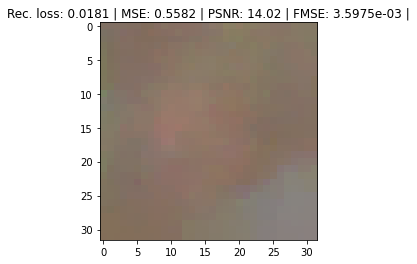

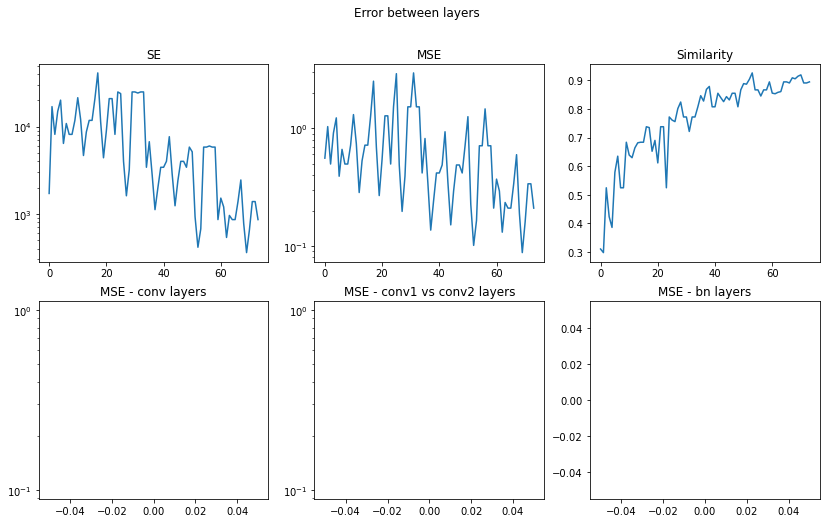

In [90]:
config = dict(signed=True,
              boxed=True,
              cost_fn='sim',
              indices='def',
              weights='equal',
              lr=1,
              optim='adam',
              restarts=1,
              max_iterations=2000,
              total_variation=1e-1,
              init='randn',
              filter='none',
              lr_decay=True,
              scoring_choice='loss')

rec_machine = inversefed.GradientReconstructor(model, (dm, ds), config, num_images=1)
output, stats = rec_machine.reconstruct(input_gradient, labels, img_shape=(3, 32, 32))

test_mse = (output.detach() - ground_truth).pow(2).mean()
feat_mse = (model(output.detach())- model(ground_truth)).pow(2).mean()  
test_psnr = inversefed.metrics.psnr(output, ground_truth, factor=1/ds)

plot(output)
plt.title(f"Rec. loss: {stats['opt']:2.4f} | MSE: {test_mse:2.4f} "
          f"| PSNR: {test_psnr:4.2f} | FMSE: {feat_mse:2.4e} |");

data = inversefed.metrics.activation_errors(model, output, ground_truth)

fig, axes = plt.subplots(2, 3, sharey=False, figsize=(14,8))
axes[0, 0].semilogy(list(data['se'].values())[:-3])
axes[0, 0].set_title('SE')
axes[0, 1].semilogy(list(data['mse'].values())[:-3])
axes[0, 1].set_title('MSE')
axes[0, 2].plot(list(data['sim'].values())[:-3])
axes[0, 2].set_title('Similarity')

convs = [val for key, val in data['mse'].items() if 'conv' in key]
axes[1, 0].semilogy(convs)
axes[1, 0].set_title('MSE - conv layers')
convs = [val for key, val in data['mse'].items() if 'conv1' in key]
axes[1, 1].semilogy(convs)
convs = [val for key, val in data['mse'].items() if 'conv2' in key]
axes[1, 1].semilogy(convs)
axes[1, 1].set_title('MSE - conv1 vs conv2 layers')
bns = [val for key, val in data['mse'].items() if 'bn' in key]
axes[1, 2].plot(bns)
axes[1, 2].set_title('MSE - bn layers')
fig.suptitle('Error between layers');

## with median filtering

It: 24000. Rec. loss: 0.1326.
It: 24000. Rec. loss: 0.1641.
It: 24000. Rec. loss: 0.2051.
It: 24000. Rec. loss: 0.2027.
It: 24000. Rec. loss: 0.1833.
It: 24000. Rec. loss: 0.1631.
It: 24000. Rec. loss: 0.1630.
It: 24000. Rec. loss: 0.1979.
Choosing optimal result ...
Optimal result score: 0.1620
Total time: 8034.342928171158.


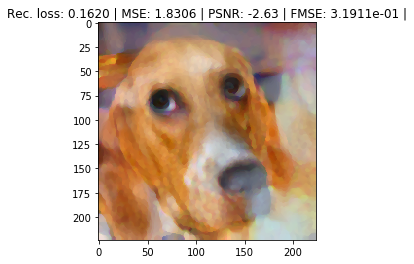

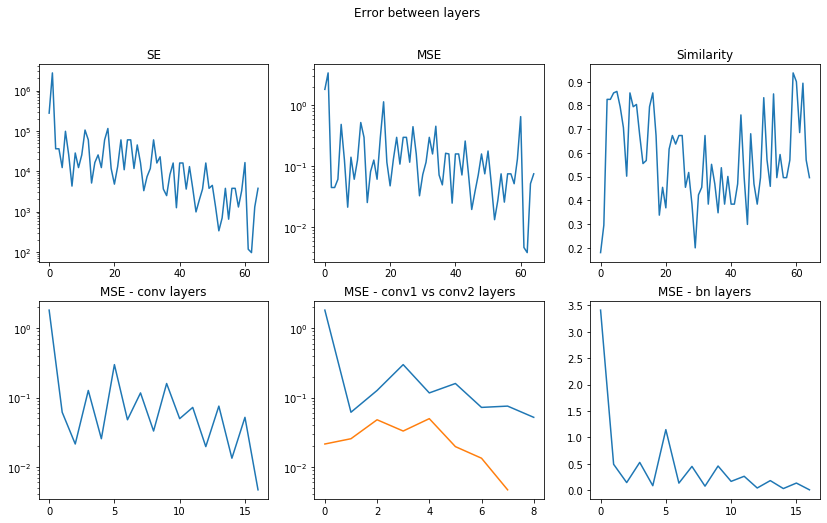

In [11]:
config = dict(signed=True,
              boxed=True,
              cost_fn='sim',
              indices='def',
              weights='equal',
              lr=1,
              optim='adam',
              restarts=8,
              max_iterations=24_000,
              total_variation=1e-1,
              init='randn',
              filter='median',
              lr_decay=True,
              scoring_choice='loss')

rec_machine = inversefed.GradientReconstructor(model, (dm, ds), config, num_images=1)
output, stats = rec_machine.reconstruct(input_gradient, labels, img_shape=(3, 224, 224))

test_mse = (output.detach() - ground_truth).pow(2).mean()
feat_mse = (model(output.detach())- model(ground_truth)).pow(2).mean()  
test_psnr = inversefed.metrics.psnr(output, ground_truth)

plot(output)
plt.title(f"Rec. loss: {stats['opt']:2.4f} | MSE: {test_mse:2.4f} "
          f"| PSNR: {test_psnr:4.2f} | FMSE: {feat_mse:2.4e} |");

data = inversefed.metrics.activation_errors(model, output, ground_truth)

fig, axes = plt.subplots(2, 3, sharey=False, figsize=(14,8))
axes[0, 0].semilogy(list(data['se'].values())[:-3])
axes[0, 0].set_title('SE')
axes[0, 1].semilogy(list(data['mse'].values())[:-3])
axes[0, 1].set_title('MSE')
axes[0, 2].plot(list(data['sim'].values())[:-3])
axes[0, 2].set_title('Similarity')

convs = [val for key, val in data['mse'].items() if 'conv' in key]
axes[1, 0].semilogy(convs)
axes[1, 0].set_title('MSE - conv layers')
convs = [val for key, val in data['mse'].items() if 'conv1' in key]
axes[1, 1].semilogy(convs)
convs = [val for key, val in data['mse'].items() if 'conv2' in key]
axes[1, 1].semilogy(convs)
axes[1, 1].set_title('MSE - conv1 vs conv2 layers')
bns = [val for key, val in data['mse'].items() if 'bn' in key]
axes[1, 2].plot(bns)
axes[1, 2].set_title('MSE - bn layers')
fig.suptitle('Error between layers');